### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 8
### Дисциплина: Методы машинного обучения

##### Студент:  Мажитов Магомед Асхабович

##### Группа:   НКНбд-01-21

## Москва 2024
***

### _**Задание:**_

Вариант 3

1. Набор данных oxford_iiit_pet с изменением разрешения до 96x96

2. Классы с метками 1,20,30,35

3. Требования к архитектуре сети CNN:

- Функциональный API при создании

- Функция потерь: разреженная категориальная кросс-энтропия

- Кол-во сверточных слоев 4

- Количество фильтров в сверточных слоях 16

- Размеры фильтра 4х4

- Использование слоев пакетной нормализации

4. Требования к архитектуре сети трансформер:

Функция потерь: категориальная кросс-энтропия

5. Показатель качества многоклассовой классификации:

минимальная точность классов, где точность (precision) класса равна доле правильных предсказаний для всех точек, относимых классификатором к этому классу.



### _**Решение:**_

Перед началом работы загрузим все необходимые библиотеки:

In [2]:
!pip show keras

Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


In [3]:
!pip install --upgrade tensorflow keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fou

In [4]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Keras v.3 !

In [5]:
%load_ext autoreload
%autoreload 2
import keras
from keras import layers, models, losses, callbacks
from keras import ops

import numpy as np
import matplotlib.pyplot as plt
import json
import re
import string
from IPython.display import display, HTML

import tensorflow as tf
import tensorflow_datasets as tfds

### _Пункт 1_

Считываем из TFDS набор данных *oxford_iiit_pet*

In [6]:
ds = tfds.load("dtd", split='train')
df = tfds.as_dataframe(ds)
df.sample(3)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1880 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/dtd/incomplete.MUWH31_3.0.1/dtd-train.tfrecord*...:   0%|          | 0/188…

Generating test examples...:   0%|          | 0/1880 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/dtd/incomplete.MUWH31_3.0.1/dtd-test.tfrecord*...:   0%|          | 0/1880…

Generating validation examples...:   0%|          | 0/1880 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/dtd/incomplete.MUWH31_3.0.1/dtd-validation.tfrecord*...:   0%|          | …

Dataset dtd downloaded and prepared to /root/tensorflow_datasets/dtd/3.0.1. Subsequent calls will reuse this data.


,file_name,image,label
1208,b'lacelike/lacelike_0031.jpg',"[[[248, 248, 248], [221, 221, 221], [175, 175,...",21
839,b'frilly/frilly_0015.jpg',"[[[65, 48, 0], [63, 46, 0], [69, 48, 0], [71, ...",14
235,b'veined/veined_0074.jpg',"[[[222, 150, 226], [223, 147, 222], [255, 226,...",42


Сначала разделим весь датасет на выборки

In [7]:
split_size = int(df.shape[0] * 0.4)

df_train = df[split_size:]
df_test1 = df[:split_size]

df_train.shape, df_test1.shape

split_size1 = int(df_test1.shape[0] * 0.5)

df_val = df_test1[split_size1:]
df_test = df_test1[:split_size1]

df_train.shape, df_val.shape, df_test.shape

((1128, 3), (376, 3), (376, 3))

In [8]:
df_train.iloc[0]['image'].shape

(508, 630, 3)

Оставим изображение только с метками *1, 20, 30, 35*:

In [9]:
df_train = df_train[(df_train.label == 1) | (df_train.label == 20)
                    | (df_train.label == 30) | (df_train.label == 35)]
df_val = df_val[(df_val.label == 1) | (df_val.label == 20)
                    | (df_val.label == 30) | (df_val.label == 35)]
df_test = df_test[(df_test.label == 1) | (df_test.label == 20)
                    | (df_test.label == 30) | (df_test.label == 35)]

Перекодируем метки классов в `0`, `1`, `2`, `3`, `4`:

In [10]:
label_mapping = {1: 0, 20: 1, 30: 2, 35: 3}

df_train['label'] = df_train['label'].map(label_mapping)
df_val['label'] = df_val['label'].map(label_mapping)
df_test['label'] = df_test['label'].map(label_mapping)

In [11]:
train_images = np.zeros((df_train.shape[0], 96, 96, 3), dtype=np.float32)
val_images = np.zeros((df_val.shape[0], 96, 96, 3), dtype=np.float32)
test_images = np.zeros((df_test.shape[0], 96, 96, 3), dtype=np.float32)

train_labels = np.array(df_train['label'])
val_labels = np.array(df_val['label'])
test_labels = np.array(df_test['label'])

In [12]:
from PIL import Image, ImageOps

for idx in range(train_labels.shape[0]):
    image = Image.fromarray(df_train.iloc[idx]['image'])
    image = image.resize((96, 96))
    train_images[idx] = np.array(image)

for idx in range(val_labels.shape[0]):
    image = Image.fromarray(df_val.iloc[idx]['image'])
    image = image.resize((96, 96))
    val_images[idx] = np.array(image)

for idx in range(test_labels.shape[0]):
    image = Image.fromarray(df_test.iloc[idx]['image'])
    image = image.resize((96, 96))
    test_images[idx] = np.array(image)

In [13]:
train_images /= 255
val_images /= 255
test_images  /= 255

In [14]:
train_images.shape, val_images.shape, test_images.shape

((102, 96, 96, 3), (29, 96, 96, 3), (29, 96, 96, 3))

### _Пункт 2_

Визуализируем по одному изображению из каждого класса:

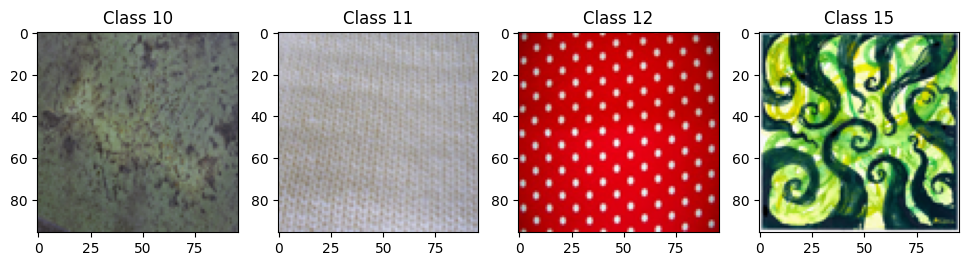

In [15]:
label_list = (10, 11, 12, 15, 20)
label_list_new = (0, 1, 2, 3, 4)
plt.figure(figsize=(15, 8))
k=0
for lab in label_list_new:
    k+=1
    for i in range(0, 102): # размер тестовой выборки, из которой будем отрисовывать изображения
        if df_train.iloc[i]['label'] == lab:
            img = Image.fromarray(df_train.iloc[i]['image'])
            img = img.resize((96, 96))
            plt.subplot(1, len(label_list), k)
            plt.imshow(img)
            plt.title(f'Class {label_list[lab]}')

### _Пункт 3_

#### ***CNN***

Так как в этом задани не описаны требования к архитектуре сети CNN - архитектура будет следущая:

- Функциональный API при создании

- Функция потерь: разреженная категориальная кросс-энтропия

- Кол-во сверточных слоев 4

- Количество фильтров в сверточных слоях 16

- Размеры фильтра 4х4

- Использование слоев пакетной нормализации

In [16]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Первый сверточный слой
    x = Conv2D(16, (4, 4), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Второй сверточный слой
    x = Conv2D(16, (4, 4), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Третий сверточный слой
    x = Conv2D(16, (4, 4), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Четвертый сверточный слой
    x = Conv2D(16, (4, 4), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [20]:
print(train_images.shape)
train_images = train_images.astype('float32')
val_images = val_images.astype('float32')
test_images = test_images.astype('float32')

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

(102, 96, 96, 3)


In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
input_shape = (96, 96, 3)
num_classes = 4

cnn_model = build_cnn_model(input_shape, num_classes)

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

cnn_early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_history = cnn_model.fit(
    train_images,
    train_labels,
    epochs=30,
    batch_size=128,
    validation_data=(val_images, val_labels),
    callbacks=[callback]
)

cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_dataset)
print(f"Тестовая потеря CNN: {cnn_test_loss}")
print(f"Тестовая точность CNN: {cnn_test_accuracy}")

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.1961 - loss: 3.5546 - val_accuracy: 0.2414 - val_loss: 1.3864
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2843 - loss: 2.0561 - val_accuracy: 0.2069 - val_loss: 1.3885
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4118 - loss: 1.6261 - val_accuracy: 0.2069 - val_loss: 1.3878
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4608 - loss: 1.5000 - val_accuracy: 0.2759 - val_loss: 1.3846
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5588 - loss: 1.2871 - val_accuracy: 0.3448 - val_loss: 1.3812
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5588 - loss: 1.0736 - val_accuracy: 0.4138 - val_loss: 1.3807
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6667 - loss: 0.8330 - val_accuracy: 0.3793 - val_loss: 1.3798
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7059 - loss: 0.7744 - val_accuracy: 0.3793 - val_loss: 1.3802
Epoch 9/30
1/1 ━

#### ***RNN***

In [30]:
from tensorflow.keras.layers import Input, LSTM, Dense, Reshape, Flatten
from tensorflow.keras.models import Model

def build_rnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Reshape((input_shape[0], input_shape[1] * input_shape[2]))(inputs)  # (96, 96 * 3)
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(128)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (96, 96, 3)
num_classes = len(label_mapping)

rnn_model = build_rnn_model(input_shape, num_classes)
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rnn_history = rnn_model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=32)

rnn_test_loss, rnn_test_accuracy = rnn_model.evaluate(test_images, test_labels)
print(f"Тестовая потеря RNN: {rnn_test_loss}")
print(f"Тестовая точность RNN: {rnn_test_accuracy}")


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 629ms/step - accuracy: 0.2350 - loss: 1.4145 - val_accuracy: 0.2069 - val_loss: 1.3975
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.3112 - loss: 1.3915 - val_accuracy: 0.2069 - val_loss: 1.4406
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.2738 - loss: 1.3795 - val_accuracy: 0.2069 - val_loss: 1.4459
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - accuracy: 0.3080 - loss: 1.3407 - val_accuracy: 0.2759 - val_loss: 1.3953
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 376ms/step - accuracy: 0.4757 - loss: 1.3148 - val_accuracy: 0.3103 - val_loss: 1.3900
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step - accuracy: 0.4080 - loss: 1.2853 - val_accuracy: 0.2759 - val_loss: 1.4593
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 527ms/step - accuracy: 0.4658 - loss: 1.2394 - val_accuracy: 0.3448 - val_loss: 1.3964
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step - accuracy: 0.4938 - loss: 1.2140 - val_accuracy: 0.3103 - val_loss:

#### ***Трансформер***

In [55]:
inputs = layers.Input(shape=(96, 96, 3))
x = inputs

encoder_output = layers.Dense(64, activation='relu')(x)


decoder_output = layers.Flatten()(encoder_output)
decoder_output = layers.Dense(5, activation='softmax')(decoder_output)

transformer_model = Model(inputs=inputs, outputs=decoder_output)

transformer_model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=RMSprop(),
    metrics=['accuracy']
)

transformer_model.summary()

transformer_history = transformer_model.fit(
    train_images,
    train_labels1,
    epochs=30,
    batch_size=128,
    validation_data=(val_images, val_labels1),
    callbacks=[callback]
)

num_epochs_04 = len(history_04.history['loss'])
print("Количество эпох обучения:", num_epochs_04)

Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)          │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 96, 96, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 589824)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 5)                   │       2,949,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,949,381 (11.25 MB)

 Trainable params: 2,949,381 (11.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1176 - loss: 1.6470 - val_accuracy: 0.2069 - val_loss: 17.6651
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3333 - loss: 9.8251 - val_accuracy: 0.2759 - val_loss: 49.7744
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2745 - loss: 54.5492 - val_accuracy: 0.1724 - val_loss: 67.4742
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3431 - loss: 58.9149 - val_accuracy: 0.3448 - val_loss: 80.0209
Количество эпох обучения: 4


#### ***MLP***

In [45]:
print(type(train_images), type(train_labels))
print(type(val_images), type(val_labels))      # Должны быть numpy.ndarray
print(type(test_images), type(test_labels))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [47]:
def build_mlp_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

mlp_model = build_mlp_model(input_shape=(96, 96, 3), num_classes=num_classes)
mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

mlp_early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

mlp_history = mlp_model.fit(train_images,
                            train_labels,
                            epochs=50,
                            validation_data=(val_images, val_labels),
                            batch_size=32,
                            callbacks=[mlp_early_stopping])

mlp_test_loss, mlp_test_accuracy = mlp_model.evaluate(test_images, test_labels)
print(f"Тестовая потеря MLP: {mlp_test_loss}")
print(f"Тестовая точность MLP: {mlp_test_accuracy}")


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2272 - loss: 13.7821 - val_accuracy: 0.3103 - val_loss: 26.0324
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step - accuracy: 0.2887 - loss: 27.8714 - val_accuracy: 0.2069 - val_loss: 32.7446
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 0.3678 - loss: 20.0245 - val_accuracy: 0.3448 - val_loss: 20.9651
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.3566 - loss: 11.5554 - val_accuracy: 0.2759 - val_loss: 8.6386
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step - accuracy: 0.2246 - loss: 7.2647 - val_accuracy: 0.2414 - val_loss: 2.2619
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.4819 - loss: 2.1410 - val_accuracy: 0.2414 - val_loss: 4.7693
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.3683 - loss: 3.3200 - val_accuracy: 0.2414 - val_loss: 3.7078
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - accuracy: 0.5010 - loss: 2.0208 - val_accuracy: 0.2069 - val_

### _Пункт 4_

#### ***Матрицы ошибок сети MLP***

In [49]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Получение предсказаний для обучающей выборки
train_predictions = mlp_model.predict(train_images)
train_predicted_labels = tf.argmax(train_predictions, axis=1)

# Получение предсказаний для тестовой выборки
test_predictions = mlp_model.predict(test_images)
test_predicted_labels = tf.argmax(test_predictions, axis=1)

train_true_labels = tf.argmax(train_labels1, axis=1)
train_confusion_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
print("ОБУЧАЮЩАЯ ВЫБОРКА:")
print(train_confusion_matrix)

test_true_labels = tf.argmax(test_labels1, axis=1)
test_confusion_matrix = confusion_matrix(test_true_labels, test_predicted_labels)
print("\nТЕСТОВАЯ ВЫБОРКА:")
print(test_confusion_matrix)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
ОБУЧАЮЩАЯ ВЫБОРКА:
[[22  1  0  4]
 [11  2  4  6]
 [ 7  0 14  5]
 [ 4  0  0 22]]

ТЕСТОВАЯ ВЫБОРКА:
[[5 0 0 3]
 [1 1 3 4]
 [5 0 1 2]
 [2 0 1 1]]


#### ***Матрицы ошибок сети CNN***

In [50]:
train_predictions = cnn_model.predict(train_images)
train_predicted_labels = tf.argmax(train_predictions, axis=1)

test_predictions = cnn_model.predict(test_images)
test_predicted_labels = tf.argmax(test_predictions, axis=1)

train_true_labels = tf.argmax(train_labels1, axis=1)
train_confusion_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
print("ОБУЧАЮЩАЯ ВЫБОРКА:")
print(train_confusion_matrix)

test_true_labels = tf.argmax(test_labels1, axis=1)
test_confusion_matrix = confusion_matrix(test_true_labels, test_predicted_labels)
print("\nТЕСТОВАЯ ВЫБОРКА:")
print(test_confusion_matrix)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
ОБУЧАЮЩАЯ ВЫБОРКА:
[[11  0 16  0]
 [ 7  1 14  1]
 [ 6  0 19  1]
 [ 7  1 17  1]]

ТЕСТОВАЯ ВЫБОРКА:
[[4 0 4 0]
 [3 0 6 0]
 [4 0 4 0]
 [2 0 2 0]]


#### ***Матрицы ошибок сети RNN***

In [51]:
train_predictions = rnn_model.predict(train_images)
train_predicted_labels = tf.argmax(train_predictions, axis=1)

test_predictions = rnn_model.predict(test_images)
test_predicted_labels = tf.argmax(test_predictions, axis=1)

train_true_labels = tf.argmax(train_labels1, axis=1)
train_confusion_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
print("ОБУЧАЮЩАЯ ВЫБОРКА:")
print(train_confusion_matrix)

test_true_labels = tf.argmax(test_labels1, axis=1)
test_confusion_matrix = confusion_matrix(test_true_labels, test_predicted_labels)
print("\nТЕСТОВАЯ ВЫБОРКА:")
print(test_confusion_matrix)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
ОБУЧАЮЩАЯ ВЫБОРКА:
[[26  0  0  1]
 [14  0  6  3]
 [ 9  0 15  2]
 [ 9  0  2 15]]

ТЕСТОВАЯ ВЫБОРКА:
[[5 0 1 2]
 [4 0 5 0]
 [5 0 1 2]
 [1 0 1 2]]


#### ***Матрицы ошибок сети Трансформер***

In [52]:
train_predictions = transformer_model.predict(train_images)
train_predicted_labels = tf.argmax(train_predictions, axis=1)

test_predictions = transformer_model.predict(test_images)
test_predicted_labels = tf.argmax(test_predictions, axis=1)

train_true_labels = tf.argmax(train_labels1, axis=1)
train_confusion_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
print("ОБУЧАЮЩАЯ ВЫБОРКА:")
print(train_confusion_matrix)

test_true_labels = tf.argmax(test_labels1, axis=1)
test_confusion_matrix = confusion_matrix(test_true_labels, test_predicted_labels)
print("\nТЕСТОВАЯ ВЫБОРКА:")
print(test_confusion_matrix)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
ОБУЧАЮЩАЯ ВЫБОРКА:
[[ 0  0 27  0]
 [ 0  0 23  0]
 [ 0  0 26  0]
 [ 0  0 26  0]]

ТЕСТОВАЯ ВЫБОРКА:
[[0 0 8 0]
 [0 0 9 0]
 [0 0 8 0]
 [0 0 4 0]]


### _Пункт 5_

In [56]:
# Получение потерь из историй обучения
losses_mlp = np.array(mlp_history.history['loss'])
val_losses_mlp = np.array(mlp_history.history['val_loss'])
initial_loss_mlp = losses_mlp[0]

losses_cnn = np.array(cnn_history.history['loss'])
val_losses_cnn = np.array(cnn_history.history['val_loss'])
initial_loss_cnn = losses_cnn[0]

losses_rnn = np.array(rnn_history.history['loss'])
val_losses_rnn = np.array(rnn_history.history['val_loss'])
initial_loss_rnn = losses_rnn[0]

losses_transformer = np.array(transformer_history.history['loss'])
val_losses_transformer = np.array(transformer_history.history['val_loss'])
initial_loss_transformer = losses_transformer[0]

# Нормализация потерь
def normalize_losses(losses, initial_loss):
    std_losses = (losses - np.mean(losses)) / np.std(losses)
    norm_std_losses = std_losses / initial_loss
    return norm_std_losses

norm_std_losses_mlp = normalize_losses(losses_mlp, initial_loss_mlp)
norm_std_val_losses_mlp = normalize_losses(val_losses_mlp, initial_loss_mlp)

norm_std_losses_cnn = normalize_losses(losses_cnn, initial_loss_cnn)
norm_std_val_losses_cnn = normalize_losses(val_losses_cnn, initial_loss_cnn)

norm_std_losses_rnn = normalize_losses(losses_rnn, initial_loss_rnn)
norm_std_val_losses_rnn = normalize_losses(val_losses_rnn, initial_loss_rnn)

norm_std_losses_transformer = normalize_losses(losses_transformer, initial_loss_transformer)
norm_std_val_losses_transformer = normalize_losses(val_losses_transformer, initial_loss_transformer)


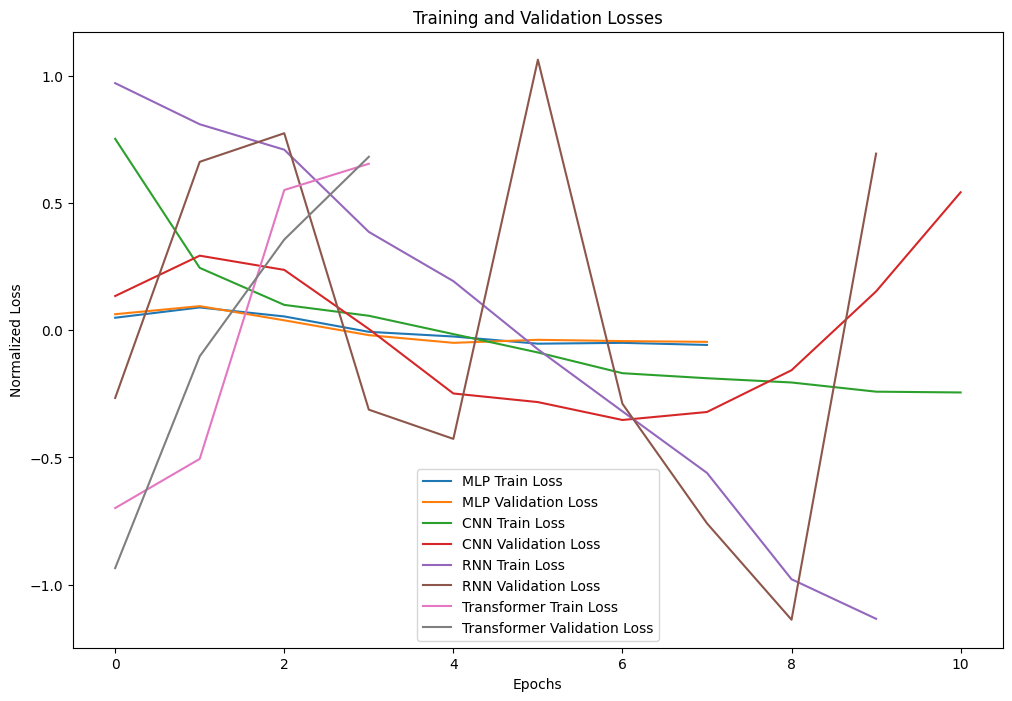

In [58]:
# Визуализация
plt.figure(figsize=(12, 8))

plt.plot(norm_std_losses_mlp, label='MLP Train Loss')
plt.plot(norm_std_val_losses_mlp, label='MLP Validation Loss')

plt.plot(norm_std_losses_cnn, label='CNN Train Loss')
plt.plot(norm_std_val_losses_cnn, label='CNN Validation Loss')

plt.plot(norm_std_losses_rnn, label='RNN Train Loss')
plt.plot(norm_std_val_losses_rnn, label='RNN Validation Loss')

plt.plot(norm_std_losses_transformer, label='Transformer Train Loss')
plt.plot(norm_std_val_losses_transformer, label='Transformer Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Normalized Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

### _Пункт 6_

Показатель качества [__`precision_score`__](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) - будем использовать уже готовую функцию,
<br>
но также можно и написать свою, тк `precision = tp / (tp + fp)`

In [66]:
from sklearn.metrics import precision_score

mlp_predictions = mlp_model.predict(test_images)
cnn_predictions = cnn_model.predict(test_images)
rnn_predictions = rnn_model.predict(test_images)
tra_predictions = transformer_model.predict(test_images)

# Построение матриц ошибок
mlp_test_predictions = np.argmax(mlp_predictions, axis=1)
cnn_test_predictions = np.argmax(cnn_predictions, axis=1)
rnn_test_predictions = np.argmax(rnn_predictions, axis=1)
transformer_test_predictions = np.argmax(tra_predictions, axis=1)

# Вычисление точности (precision) для каждого класса
mlp_precision = precision_score(test_labels, m_predicted_classes, average='macro')
cnn_precision = precision_score(test_labels, c_predicted_classes, average='macro')
rnn_precision = precision_score(test_labels, r_predicted_classes, average='macro')
tra_precision = precision_score(test_labels, t_predicted_classes, average='macro')


mlp_precision, cnn_precision, rnn_precision, tra_precision

# Определение модели с наивысшей минимальной точностью классов
best_model_name = ''
best_min_precision = 0

if mlp_precision >= best_min_precision:
    best_min_precision = mlp_precision
    best_model_name = 'MLP'

if cnn_precision >= best_min_precision:
    best_min_precision = cnn_precision
    best_model_name = 'CNN'

if rnn_precision >= best_min_precision:
    best_min_precision = rnn_precision
    best_model_name = 'RNN'

if tra_precision >= best_min_precision:
    best_min_precision = tra_precision
    best_model_name = 'Transformer'

print(f"Модель с наилучшей минимальной точностью классов: {best_model_name} с точностью {best_min_precision:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Модель с наилучшей минимальной точностью классов: MLP с точностью 0.4212


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
